# Well log wedge

Let's try to make a wedge model from a well log!

We'll try linear wedges and a sort of sigmoid thing.

**Watch out, this is all rather experimental.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

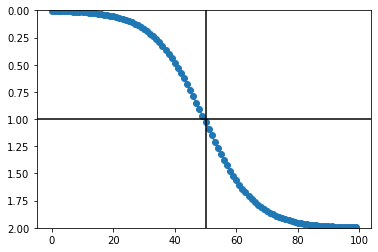

In [2]:
def sigmoid(x):
    """Logistic function.
    """
    return 2 / (1 + np.exp(-x))

plt.plot(sigmoid(np.linspace(-6, 6, 100)), 'o-')
plt.ylim(2, 0)
plt.axvline(50, c='k')
plt.axhline(1, c='k')

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from welly import Well
import scipy.ndimage as sn

w = Well.from_las('../data/R-39.las')

# Define the zone.
log, top, bot = 'GR', 2620, 2720

log_before = w.data[log].to_basis(stop=top)
log_wedge = w.data[log].to_basis(start=top, stop=bot)
log_after = w.data[log].to_basis(start=bot)

def pad_with(vector, pad_width, iaxis, kwargs):
    """Padding function."""
    vector[:pad_width[0]] = log_before[-pad_width[0]:]
    vector[-pad_width[1]:] = log_after[:pad_width[1]]

# Compute the zooms.
mode = 'sigmoid'
minz, maxz, nx = 0, 2, 400

if mode == 'linear':
    zooms = np.linspace(0.0, 2, nx+1)
elif mode == 'sigmoid':
    zooms = sigmoid(np.linspace(-5, 5, nx))
# More here later...
else:
    raise TypeError("Mode not recognized.")

# Make the base 'horizon'.
base = zooms * log_wedge.size

# Do the zooms.
wedges = [sn.zoom(log_wedge, zoom=zoom) for zoom in zooms]

# Collect wedge pieces, then pad top and bottom, then stack.
before, after = 200, 400  # samples
padded = [np.pad(wedge, [before, after+2*log_wedge.size-wedge.size], mode=pad_with) for wedge in wedges]
wedge = np.stack(padded)

# Add bookends with padding left and right.
left, right = 40, 40  # samples
wedge = np.pad(wedge, [[left, right], [0, 0]], mode='edge')
base = np.pad(base, [left, right], mode='edge')

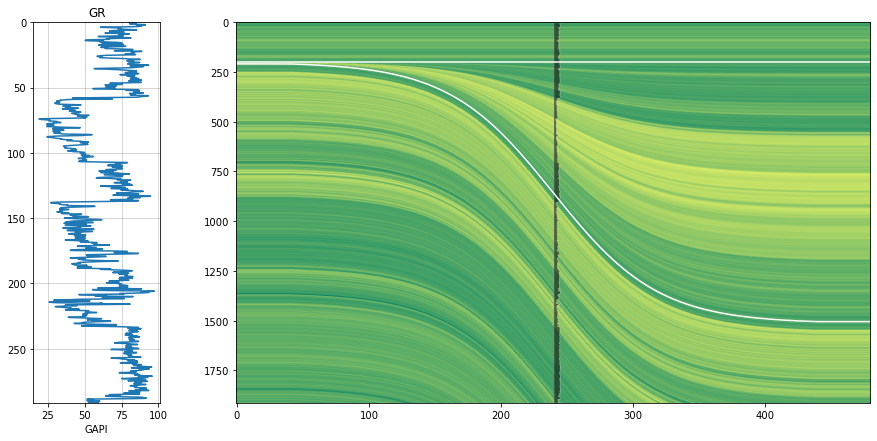

In [17]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 7), gridspec_kw={'width_ratios': [1, 5]})

log_ = wedge[left+nx//2]
z = np.arange(log_.size)
z_ = z * w.data[log].step

ax0.plot(log_, z_)
ax0.set_title(w.data[log].mnemonic)
ax0.set_xlabel(w.data[log].units)
ax0.grid(c='k', alpha=0.2)
ax0.set_ylim(z_[-1], z_[0])

ax1.imshow(wedge.T, aspect='auto', cmap='summer_r')
ax1.fill_betweenx(z, left+nx//2+log_/20, left+nx//2, color='k', lw=0.5, ec='w', alpha=0.5)
ax1.axvline(left + nx//2, c='k', alpha=0.75, lw=0.5)
ax1.axhline(before, c='w')
ax1.plot(before + base, c='w')

## Forward model

Before running this bit, make the `wedge` using the DT4P log, or make impedance.

In [11]:
vp = 1e6 / (wedge + 1e-15)
rc = (vp[:, 1:] - vp[:, :-1]) / (vp[:, 1:] + vp[:, :-1])

In [12]:
import bruges as bg

w = bg.filters.ricker(0.5, 0.002, 8, parity='odd')

/Users/matt/opt/miniconda3/envs/geocomp/lib/python3.8/site-packages/bruges/filters/wavelets.py:20: FutureWarning: In future releases, time parity will be 'odd' by default.
  warnings.warn("In future releases, time parity will be 'odd' by default.", FutureWarning)


In [13]:
syn = np.apply_along_axis(np.convolve, arr=rc, axis=1, v=w, mode='same')
syn = sn.gaussian_filter1d(syn, sigma=1, axis=0)
syn.shape

(480, 1913)

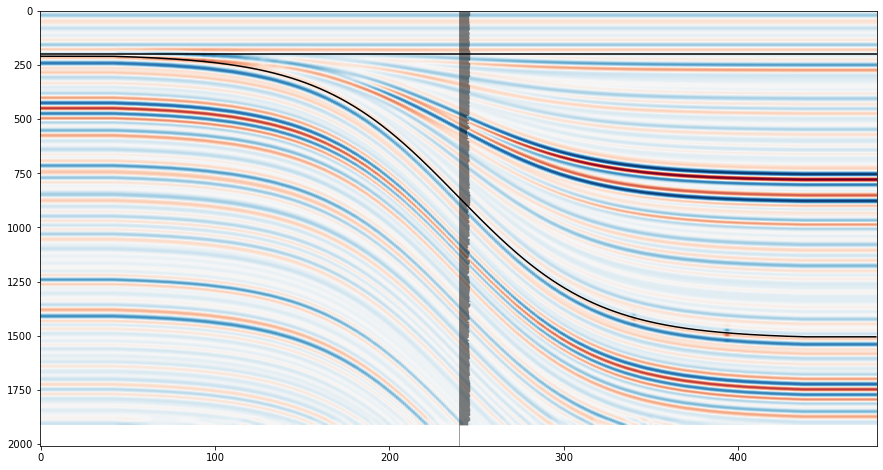

In [14]:
plt.figure(figsize=(15, 8))
plt.imshow(syn.T, aspect='auto', cmap='RdBu')
plt.fill_betweenx(z, left+nx//2+log_/50, left+nx//2, color='k', lw=0.5, ec='w', alpha=0.5)
plt.axvline(left + nx//2, c='k', alpha=0.75, lw=0.5)
plt.axhline(before, c='k', lw=1.5)
plt.plot(before + base, c='k', lw=1.5)

---
&copy; Agile Scientific, licensed CC-BY / Apache 2.0